# Prueba desempeño 

**Parámetros de la prueba:**
* Arquitectura: Mobilenet V1 
* Datos:skin-cancer-3_clases
* Data Augmentation: Yes
  * Horizontal flip : true
  * Vertical flip : true
* K-Fold Validation: No
* Hyperparameter Tuning: No

**Parámetros estáticos de entrenamiento:**
* lr = 1e-3
* init = 'normal'
* activ = 'relu'
* activ_last = 'softmax'
* optim = 'adam'
* epochs = 20
* batch_size = 64


---


*Notas:*  

* Se reemplazo la capa flatten por GlobalAveragePooling debido a que generaba problemas en el entrenamiento.En particular elevaba considerablemente el valor de las perdidas y al ser reemplazada el modelo tuvo convergencia. Se recomienda investigar que efectos tiene GlobalAveragePooling sobre la red.
* Se implemento la funcion para el Test
* Se implemento F1 Score 
* Se implemento la matriz de confusion (normalizada)


In [1]:
# Librerias Basicas 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as img
import json
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
import PIL.Image
from IPython.display import Image
np.random.seed(11) # It's my lucky number

# Librerias de preprocesamiento y metricas
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

# Librerias para backend, arquitectura y entrenamiento
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.core import Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

**Instalar los repositorios de kaggle para descargar los datos.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir Incep_BM

Mounted at /content/drive


#Ruta Raiz

In [3]:
ruta="/content/drive/MyDrive/data_todo"

**Preprocesar y organizar los datos**

In [4]:
# identificar las rutas y los nombres de las carpetas
folder_carcinoma_train = '../content/drive/MyDrive/data_todo/Train_val/basal_cell_carcinoma_and_squamous_cell_carcinoma'
folder_melanoma_train = '../content/drive/MyDrive/data_todo/Train_val/melanoma'
folder_keratosis_train= '../content/drive/MyDrive/data_todo/Train_val/pigmented_bening_keratosis'

folder_carcinoma_test = '../content/drive/MyDrive/data_todo/Test/basal_cell_carcinoma_and_squamous_cell_carcinoma'
folder_melanoma_test = '../content/drive/MyDrive/data_todo/Test/melanoma'
folder_keratosis_test = '../content/drive/MyDrive/data_todo/Test/pigmented_bening_keratosis'

train_data_dir = '../content/drive/MyDrive/data_todo/Train_val'
test_data_dir ='../content/drive/MyDrive/data_todo/Test'


read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

import cv2

def resize_img(img):
  width , height = 224,224
  resize_image = []
  full_size_image = img
  resize_image.append(cv2.resize(full_size_image, (width , height), interpolation=cv2.INTER_CUBIC))
  return resize_image[0]






# cargar las imagenes de train 

In [5]:
# cargar las imagenes de train
ims_carcinoma = [read(os.path.join(folder_carcinoma_train, filename)) for filename in os.listdir(folder_carcinoma_train)]
X_carcinoma=[]
for img in ims_carcinoma:
  X_carcinoma.append(np.array(resize_img(img), dtype='uint8'))
  
  #print (X_carcinoma)
ims_melanoma = [read(os.path.join(folder_melanoma_train, filename)) for filename in os.listdir(folder_melanoma_train)]
X_melanoma=[]
for img in ims_melanoma:
  X_melanoma.append(np.array(resize_img(img), dtype='uint8'))

ims_keratosis = [read(os.path.join(folder_keratosis_train, filename)) for filename in os.listdir(folder_keratosis_train)]
X_keratosis=[]
for img in ims_keratosis:
  X_keratosis.append(np.array(resize_img(img), dtype='uint8'))

# Cargar las imagenes de test

In [6]:
ims_carcinoma = [read(os.path.join(folder_carcinoma_test, filename)) for filename in os.listdir(folder_carcinoma_test)]
X_carcinoma_test=[]
for img in ims_carcinoma:
  X_carcinoma_test.append(np.array(resize_img(img), dtype='uint8'))

ims_melanoma = [read(os.path.join(folder_melanoma_test, filename)) for filename in os.listdir(folder_melanoma_test)]
X_melanoma_test=[]
for img in ims_melanoma:
  X_melanoma_test.append(np.array(resize_img(img), dtype='uint8'))

ims_keratosis = [read(os.path.join(folder_keratosis_test, filename)) for filename in os.listdir(folder_keratosis_test)]
X_keratosis_test=[]
for img in ims_keratosis:
  X_keratosis_test.append(np.array(resize_img(img), dtype='uint8'))


# Crear etiquetas

In [7]:
y_carcinoma = np.zeros(np.shape(X_carcinoma)[0])
y_melanoma = np.ones(np.shape(X_melanoma)[0])
y_keratosis = 2*np.ones(np.shape(X_keratosis)[0])

y_carcinoma_test = np.zeros(np.shape(X_carcinoma_test)[0])
y_melanoma_test = np.ones(np.shape(X_melanoma_test)[0])
y_keratosis_test = 2*np.ones(np.shape(X_keratosis_test)[0])



In [8]:
print("ENTRENAMIENTO")
print(np.shape(X_carcinoma))
print(np.shape(X_melanoma))
print(np.shape(X_keratosis))

ENTRENAMIENTO
(675, 224, 224, 3)
(1328, 224, 224, 3)
(1000, 224, 224, 3)


In [9]:
print("TEST")
print(np.shape(X_carcinoma_test))
print(np.shape(X_melanoma_test))
print(np.shape(X_keratosis_test))

TEST
(136, 224, 224, 3)
(239, 224, 224, 3)
(99, 224, 224, 3)


# Crear datos combinados para train y test 

In [10]:
X_train = np.concatenate((X_carcinoma, X_melanoma, X_keratosis), axis = 0)
y_train = np.concatenate((y_carcinoma, y_melanoma,y_keratosis), axis = 0)

X_test = np.concatenate((X_carcinoma_test, X_melanoma_test,X_keratosis_test), axis = 0)
y_test = np.concatenate((y_carcinoma_test, y_melanoma_test,y_keratosis_test), axis = 0) 

# Randomizar los datos

In [11]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

Graficar algunos datos para prueba (celda para opcional)

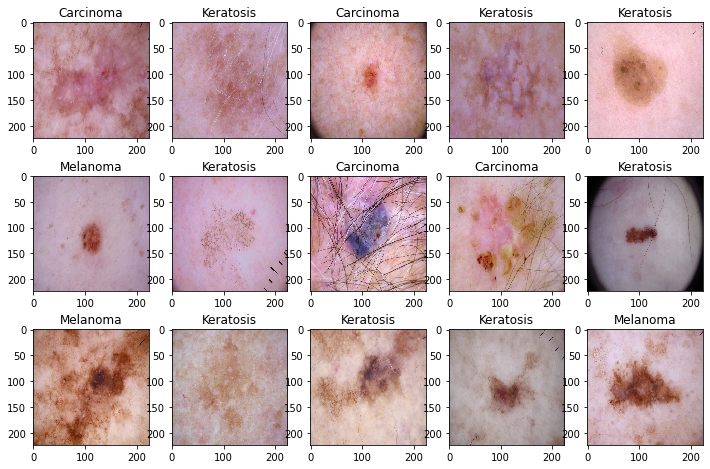

In [12]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Carcinoma')
    elif  y_train[i] == 1:
        ax.title.set_text('Melanoma')
    else:
        ax.title.set_text('Keratosis')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


# Etiquetas a categoricas 

In [13]:
y_train = to_categorical(y_train, num_classes= 3)
y_test = to_categorical(y_test, num_classes= 3)


# Normalización 

In [14]:
X_train = X_train/255.
X_test = X_test/255.

**Crear modelo Mobilenet v1**

In [15]:
base_model=MobileNet(input_shape = (224,224,3), weights='imagenet',include_top=False) # importar mobilenet y descartar la ultima capa

x=base_model.output
#x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) 
#x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x = Dropout(0.25)(x)
preds=Dense(3,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
Model.summary(model)

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

In [18]:
input_shape = (224,224,3)
lr = 1e-4
init = 'normal'
activ = 'relu'
optim = keras.optimizers.Adam(learning_rate=lr)
epochs = 20
batch_size = 32
img_height= 224
img_width = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.1,
        horizontal_flip=True,
        #zoom_range=[0.5,0.5],
        vertical_flip=True,
        validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') 

validation_generator = train_datagen.flow_from_directory(
                                                        train_data_dir, # same directory as training data
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation' # set as validation data
                                                        )

for layer in base_model.layers:
    layer.trainable = False
    
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[20:]:
#     layer.trainable=True

model.compile(optimizer = optim ,loss = "categorical_crossentropy", metrics=["accuracy"])

checkpoint_filepath = '../content/Incep_BM/best_Model2.h5'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,),
   
  #  keras.callbacks.ReduceLROnPlateau(
  #      monitor='val_loss', 
  #      factor=0.1, 
  #      patience=4,
  #      verbose=1,  
  #       min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1, 
        save_best_only=True)
  ]     

history = model.fit(train_generator, steps_per_epoch=2403/batch_size, epochs=epochs, 
                              validation_data=validation_generator, validation_steps=600/batch_size, verbose=1,
                              callbacks=callbacks_list)



Found 2403 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Epoch 1/20
75/75 [==============================] - 34s 442ms/step - loss: 0.7133 - accuracy: 0.7127 - val_loss: 0.8023 - val_accuracy: 0.6500

Epoch 00001: val_accuracy improved from -inf to 0.65000, saving model to ../content/Incep_BM/best_Model2.h5
Epoch 2/20
75/75 [==============================] - 33s 442ms/step - loss: 0.6425 - accuracy: 0.7412 - val_loss: 0.7546 - val_accuracy: 0.6550

Epoch 00002: val_accuracy improved from 0.65000 to 0.65500, saving model to ../content/Incep_BM/best_Model2.h5
Epoch 3/20
75/75 [==============================] - 33s 438ms/step - loss: 0.5725 - accuracy: 0.7715 - val_loss: 0.7089 - val_accuracy: 0.6800

Epoch 00003: val_accuracy improved from 0.65500 to 0.68000, saving model to ../content/Incep_BM/best_Model2.h5
Epoch 4/20
75/75 [==============================] - 33s 439ms/step - loss: 0.5501 - accuracy: 0.7735 - val_loss: 0.7503 - val_accuracy: 0.6533

Epoch 00004

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


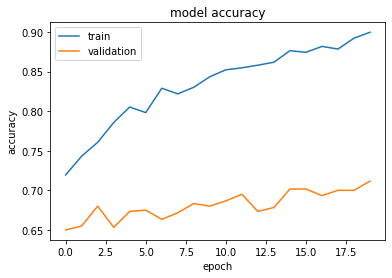

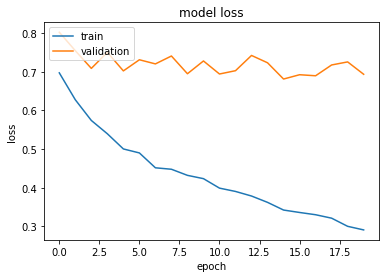

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
test_datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = test_datagen.flow_from_directory(
                                                    test_data_dir,  
                                                    target_size=(img_height,img_width), 
                                                    batch_size=batch_size,  
                                                    class_mode='categorical',
                                                    shuffle=False
                                                  )


model.load_weights(checkpoint_filepath)
model.evaluate(test_generator, batch_size=128)
data_test,label_test=test_generator[0]

import sklearn
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
y_pred = np.fix(y_pred+0.5)
print('F1 score = ',f1_score(y_test, y_pred, average='weighted'))

def get_confusion_matrix(y_true, y_pred, normalized):
    y_pred = np.where(y_pred)
    label_test = y_pred[1]
    y_test = np.where(y_true)
    index = y_test[1]
    n_classes = len(np.unique(y_true))
    M = np.zeros((n_classes, n_classes))
    cont = 0
    for n in range(0,len(index)):
        M[label_test[n]][index[n]] = M[label_test[n]][index[n]]+1
        cont = cont+1
    M.astype('int')
    if normalized == True:
        conf = np.transpose( np.transpose(M)/np.sum(M,axis=1) )
    return conf

conf = get_confusion_matrix(y_test, y_pred, True)
print('Confusion matrix = ')
print(conf)

P = conf.sum(axis=0)
R =  conf.sum(axis=1)
D = R+P
F1i = 2*np.diag(conf)/D
print('F1i Score = ')
print(F1i)

Found 474 images belonging to 3 classes.
15/15 [==============================] - 4s 228ms/step - loss: 0.4975 - accuracy: 0.7764
F1 score =  0.7735999263348543


IndexError: ignored

**Test Modelo y Evaluación del desempeño**

In [ ]:
plt.plot(history.history['lr'])